### Introduction to Statistical Learning with R
# Lab 8: Decision Trees
<br>

## 8.3.1 Fitting Classification Trees

The `tree` library is used to construct classification and regression trees.

In [3]:
library(tree)

We first use classification trees to analyze the `Carseats` data set. In these data, `Sales` is a continuous variable, and so we begin by recoding it as a binary variable. We use the `ifelse()` function to create a variable, called `High`, which takes on a value of `Yes` if the `Sales` variable exceeds 8, and takes on a value of `No` otherwise.

In [5]:
library(ISLR)
attach(Carseats)
High=ifelse(Sales<=8,"No","Yes")

Finally, we use the `data.frame()` function to merge `High` with the rest of the `Carseats` data.

In [6]:
Carseats=data.frame(Carseats,High)

We now use the `tree(0` function to fit a classification tree in order to predict `High` using all variables but `Sales`. The syntax of the `tree()` function is quite similar to that of the `lm()` function.

In [7]:
tree.carseats=tree(High~.-Sales,Carseats)

The `summary()` function lists the variables that are used as internal nodes in the tree, the number of terminal nodes, and the (training) error rate.

In [9]:
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

We see that the training error rate is 9%. For classification trees, the deviance reported in the output of `summary()` is given by 

$$-2\sum_{m}\sum_{k}n_{mk}\log \hat{p}_{mk}$$

where $n_{mk}$ is the number of observations in the *m*th terminal node that belong to the *k*th class. A small deviance indicates a tree that provides a good fit to the (training) data. The *residual mean deviance* reported is simply the deviance divided by $n-|T_{0}|$, which in this case is $400-27=373$. 

One of the most attractive properties of trees is that they can be graphically displayed. We use the `plot()` function to display the node labels. The argument `pretty=0` instructs R to include the category names for any qualitative predictors, rather than simply displaying a letter for each category.

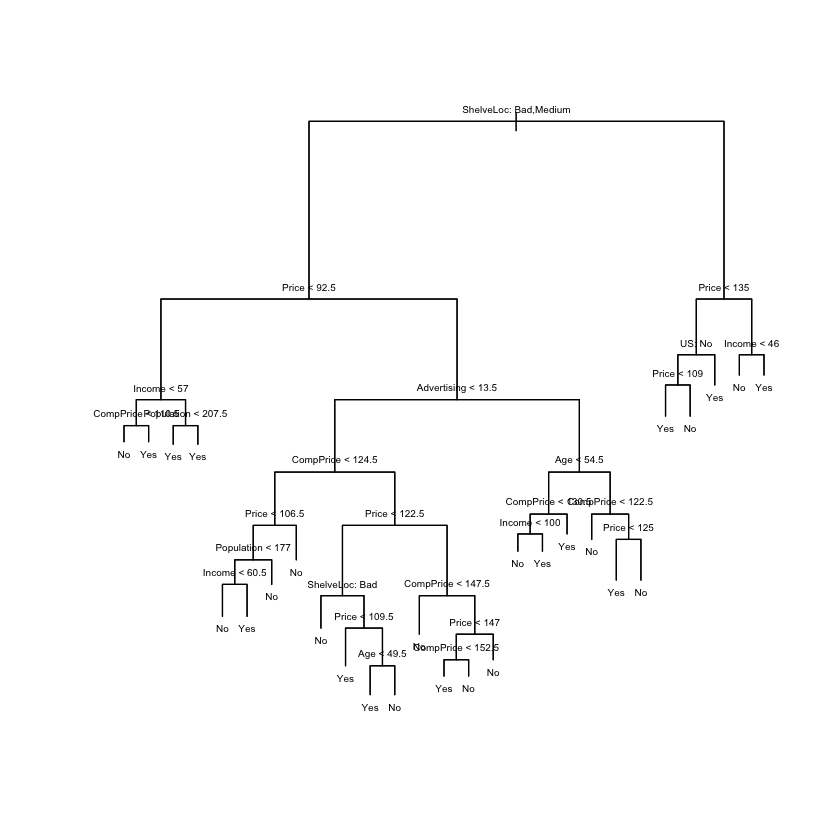

In [26]:
plot(tree.carseats)
text(tree.carseats,pretty=0,cex=0.5)

The most important indicator of `Sales` appears to be shelving location, since the first branch differentiates `Good` locations from `Bad` and `Medium` locations. 

If we just type the name of the tree object, R prints output corresponding to each branch of the tree. R displays the split criteron (e.g. `Price<92.5`), the number of observations in that branch, the deviance, the overall prediction for the branch (`Yes` or `No`), and the fraction of observations in that branch that take on values of `Yes` and `No`. Branches that lead to terminal nodes are indicated using asterisks. 

In [27]:
tree.carseats

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

In order to properly evaluate the performance of a classification tree on these data, we must estimate the test error rather than simply computing the training error. We split the observations into a training set and a test set, build the tree using the training set, and evaluate its performance on the test data. The `predict()` function can be used for this purpose In the case of a classification tree, the argument `type="class"` instructs R to return the actual class prediction. This approach leads to correct predictions for around 71.5% of the locations in the test data set.

In [30]:
set.seed(2)
train=sample(1:nrow(Carseats),200)
Carseats.test=Carseats[-train,]
High.test=High[-train]
tree.carseats=tree(High~.-Sales,Carseats,subset=train)
tree.pred=predict(tree.carseats,Carseats.test,type="class")
table(tree.pred,High.test)
(86+57)/200

         High.test
tree.pred No Yes
      No  86  27
      Yes 30  57

[1] 0.715

Next, we consider whether pruning the tree might lead to improved results. The function `cv.tree()` performs cross-validation in order to determine the optimal level of tree complexity; cost complexity pruning is used in order to select a sequence of trees for consideration. We use the argument `FUN=prune.misclass` in order to indicate that we want the classification error rate to guide the cross-validation and pruning process, rather than the default for the `cv.tree()` function, which is deviance. The `cv.tree()` function reports the number of terminal nodes of each tree considered (`size`) as well as the corresponding error rate and the value of the cost-complexity parameter used (`k`, which corresponds to $\alpha$ in (8.4)).

In [31]:
set.seed(3)
cv.carseats=cv.tree(tree.carseats,FUN=prune.misclass)
names(cv.carseats)
cv.carseats

[1] "size"   "dev"    "k"      "method"

$size
[1] 19 17 14 13  9  7  3  2  1

$dev
[1] 55 55 53 52 50 56 69 65 80

$k
[1]       -Inf  0.0000000  0.6666667  1.0000000  1.7500000  2.0000000  4.2500000
[8]  5.0000000 23.0000000

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

Note that, despite the name, `dev` corresponds to the cross-validation error rate in this instance. The tree with 9 terminal nodes results in the lowest cross-validation error rate, with 50 cross-validation errors. We plot the error rate as a function of both `size` and `k`.

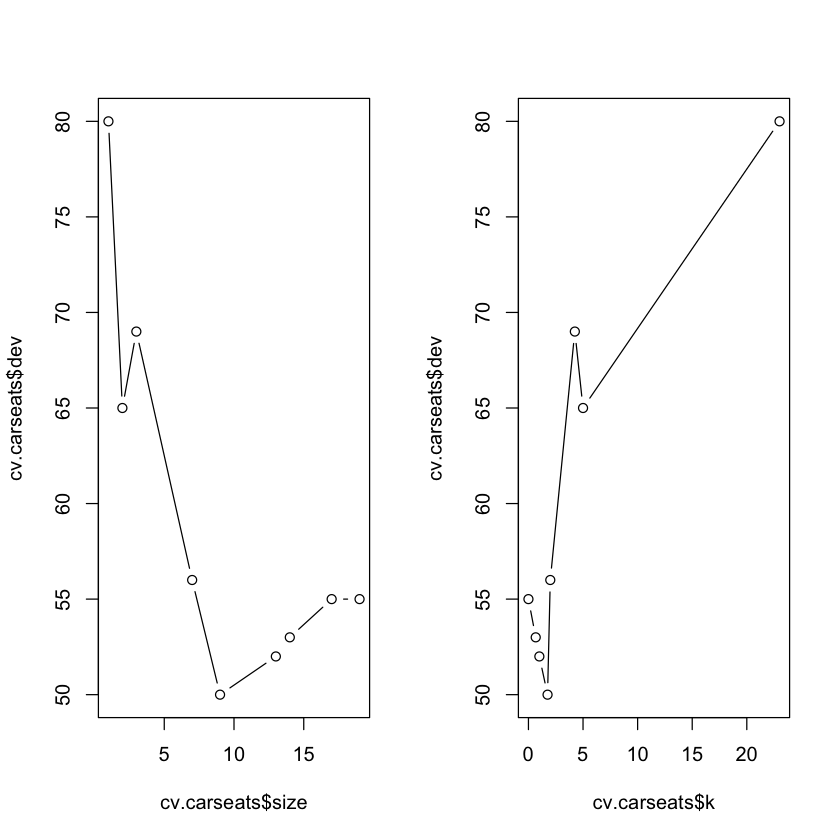

In [32]:
par(mfrow=c(1,2))
plot(cv.carseats$size,cv.carseats$dev,type="b")
plot(cv.carseats$k,cv.carseats$dev,type="b")

We now apply the `prune.misclass()` function in order to prune the tree to obtain the nine-node tree.

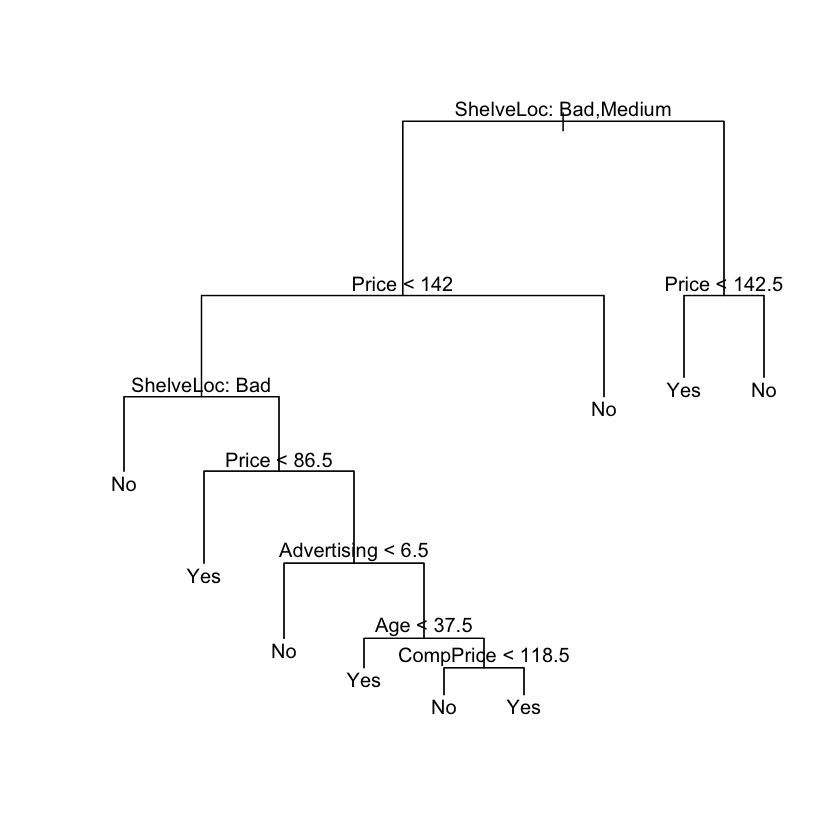

In [33]:
prune.carseats=prune.misclass(tree.carseats,best=9)
plot(prune.carseats)
text(prune.carseats,pretty=0)

How well does this pruned tree perform on the test data set? Once again, we apply the `predict()` function.

In [34]:
tree.pred=predict(prune.carseats,Carseats.test,type="class")
table(tree.pred,High.test)
(94+60)/200

         High.test
tree.pred No Yes
      No  94  24
      Yes 22  60

[1] 0.77

Now 77% of the test observations are correctly classified, so not only has the pruning process produced a more interpretable tree, but it has also improved the classification accuracy. 

If we increase the value of `best`, we obtain a larger pruned tree with a lower classification accuracy:

         High.test
tree.pred No Yes
      No  86  22
      Yes 30  62

[1] 0.74

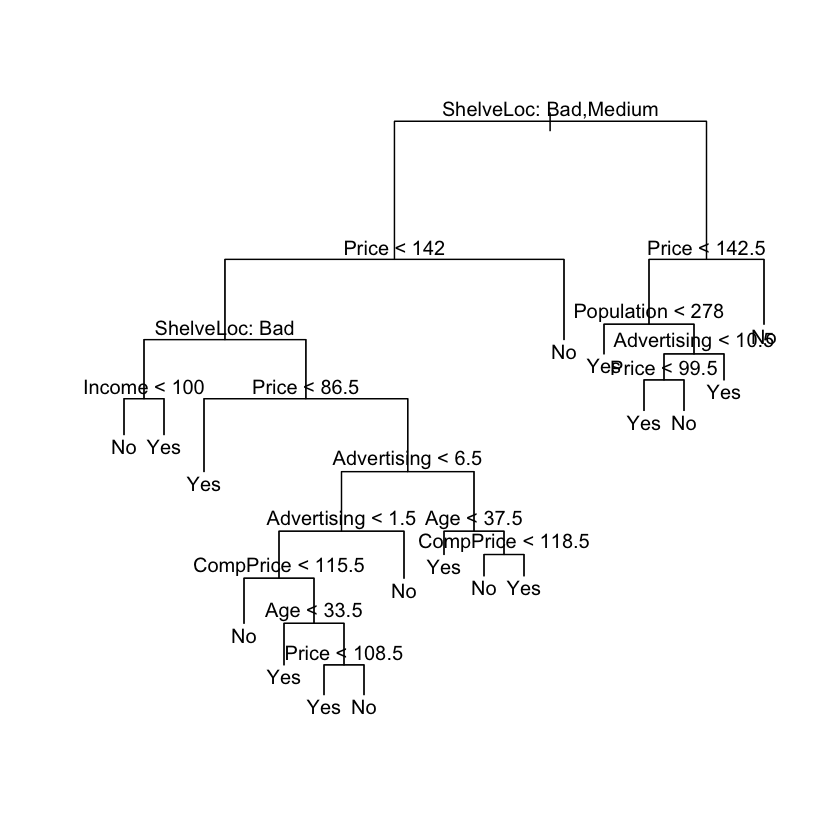

In [35]:
prune.carseats=prune.misclass(tree.carseats,best=15)
plot(prune.carseats)
text(prune.carseats,pretty=0)
tree.pred=predict(prune.carseats,Carseats.test,type="class")
table(tree.pred,High.test)
(86+62)/200

## 8.3.2 Fitting Regression Trees

Here we fit a regression tree to the `Boston` data set. First, we create a training set, and fit the tree to the training data.

In [36]:
library(MASS)
set.seed(1)
train=sample(1:nrow(Boston),nrow(Boston)/2)
tree.boston=tree(medv~.,Boston,subset=train)
summary(tree.boston)


Regression tree:
tree(formula = medv ~ ., data = Boston, subset = train)
Variables actually used in tree construction:
[1] "lstat" "rm"    "dis"  
Number of terminal nodes:  8 
Residual mean deviance:  12.65 = 3099 / 245 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-14.10000  -2.04200  -0.05357   0.00000   1.96000  12.60000 

Notice that the output of `summary()` indicates that only three of the variables have been used for constructing the tree. In the context of a regression tree, the deviance is simply the sum of squared errors for the tree. We now plot the tree.

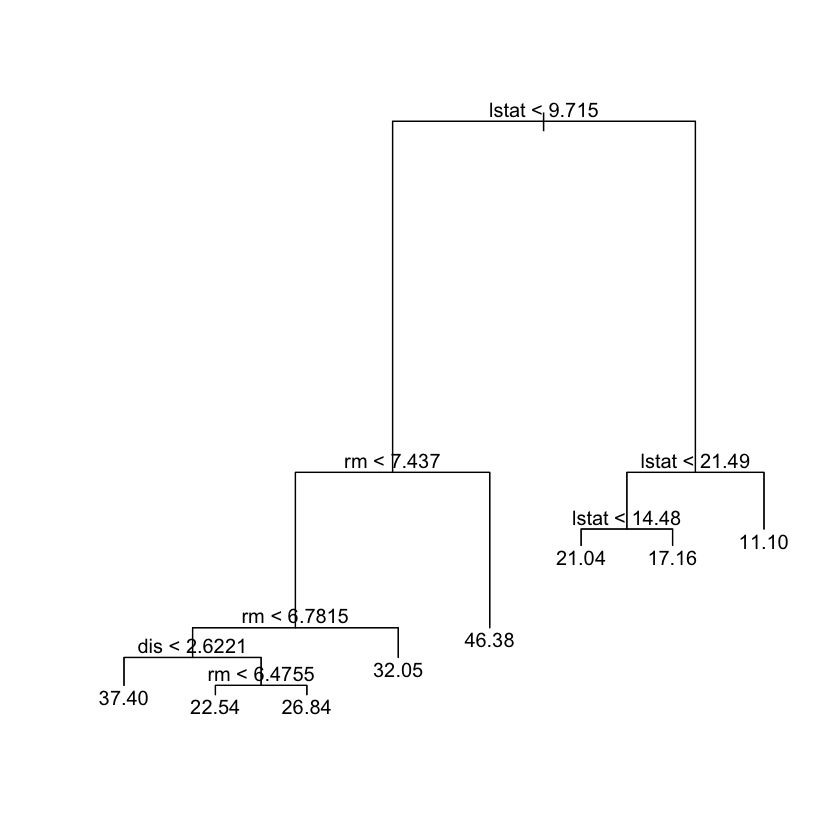

In [37]:
plot(tree.boston)
text(tree.boston,pretty=0)

The variable `lstat` measures the percentage of individuals with lower socioeconomic status. The tree indicates that lower values of `lstat` correspond to more expensive houses. The tree predicts a median house price of \$46,400 for larger homes in suburbs in which residents have high socioeconomic status (`rm>=7.437` and `lstat<9.715`).

Now we use the `cv.tree()` function to see whether pruning the tree will improve performance. 

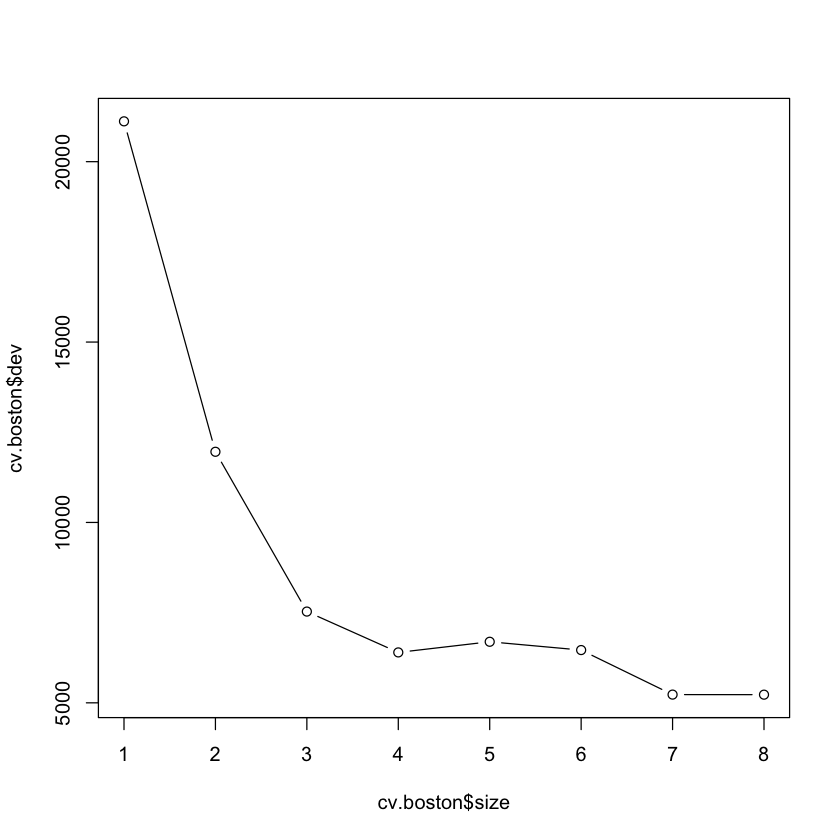

In [38]:
cv.boston=cv.tree(tree.boston)
plot(cv.boston$size,cv.boston$dev,type='b')

In this case, the most complex tree is selected by cross-validation. However, if we wish to prune the tree, we could do so as follows, using the `prune.tree()` function:

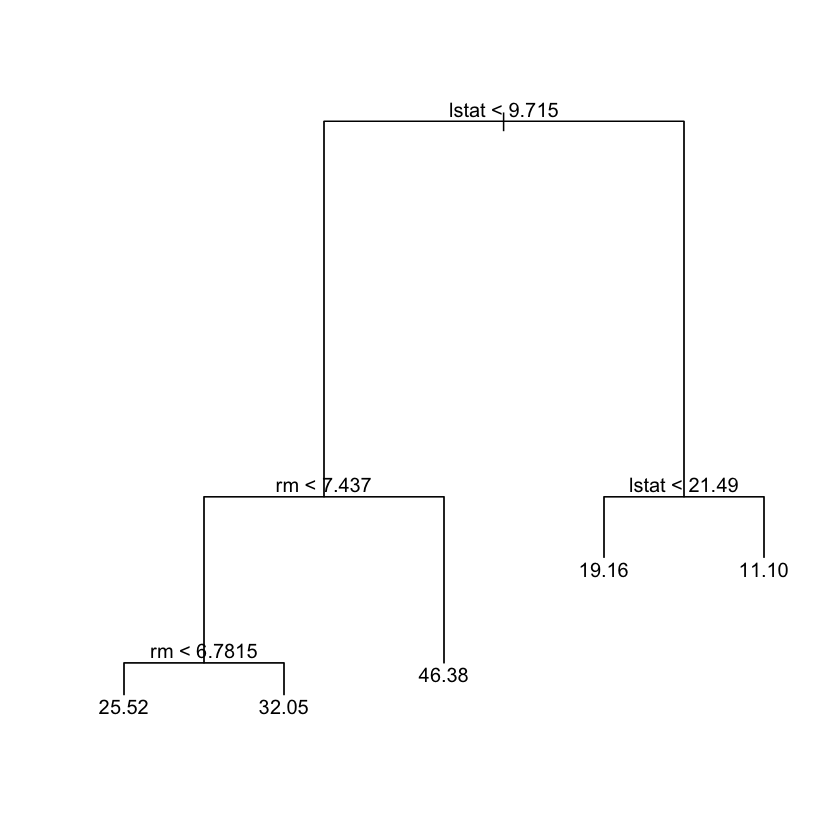

In [39]:
prune.boston=prune.tree(tree.boston,best=5)
plot(prune.boston)
text(prune.boston,pretty=0)

In keeping with the cross-validation results, we use the unpruned tree to make predictions on the test set.

[1] 25.04559

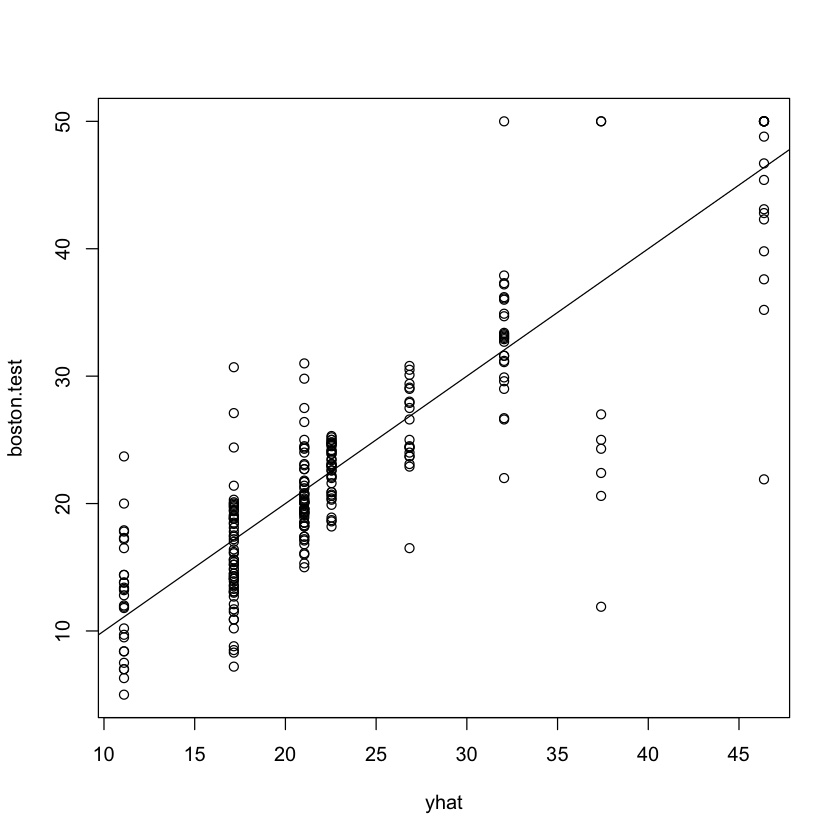

In [41]:
yhat=predict(tree.boston,newdata=Boston[-train,])
boston.test=Boston[-train,"medv"]
plot(yhat,boston.test)
abline(0,1)
mean((yhat-boston.test)^2)

In other words, the test set MSE associated with the regression tree is 25.05. The square root of the MSE is therefore around 5.005, indicating that this model leads to test predictions that are within around \$5,005 of the true median home value for the suburb.

<br><br><br>
## 8.3.3 Bagging and Random Forests

Here we apply bagging and random forests to the `Boston` data, using the `randomForest` package in R. The exact results obtained in this section may depend on the version of R and the version of the `randomForest` package installed on your computer. Recall that bagging is simply a special case of a random forest with $m=p$. Therefore, the `randomForest()` function can be used to perform both random forests and bagging. We perform bagging as follows:

In [44]:
library(randomForest)
set.seed(1)
bag.boston=randomForest(medv~.,data=Boston,subset=train,mtry=13,importance=TRUE)
bag.boston


Call:
 randomForest(formula = medv ~ ., data = Boston, mtry = 13, importance = TRUE,      subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 11.02509
                    % Var explained: 86.65

The argument `mtry=13` indicates that all 13 predictors should be considered for each split of the tree—in other words, that bagging should be done. How well does this bagged model perform on the test set?

[1] 13.47349

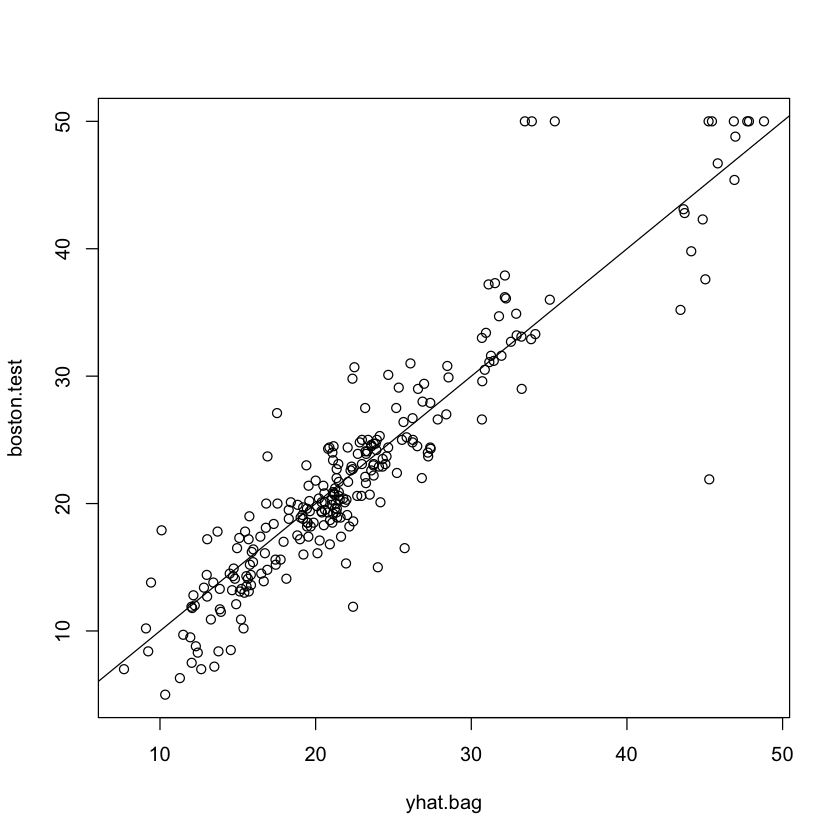

In [47]:
yhat.bag=predict(bag.boston,newdata=Boston[-train,])
plot(yhat.bag,boston.test)
abline(0,1)
mean((yhat.bag-boston.test)^2)

The test set MSE associated with the bagged regression tree is 13.16, almost half that obtained using an optimally-pruned single tree. We could change the number of trees grown by `randomForest()` using the `ntree` argument:

In [48]:
bag.boston=randomForest(medv~.,data=Boston,subset=train,mtry=13,ntree=25)
yhat.bag=predict(bag.boston,newdata=Boston[-train,])
mean((yhat.bag-boston.test)^2)

[1] 13.43068

Growing a random forest proceeds in exactly the same way, except that we use a smaller value of the `mtry` argument. By default, `randomForest()` uses $p/3$ variables when building a random forest of regression trees, and $\sqrt{p}$ variables when building a random forest of classification trees. Here we use `mtry=6`.

In [51]:
set.seed(1)
rf.boston=randomForest(medv~.,data=Boston, subset=train,mtry=6,importance=TRUE)
yhat.rf=predict(rf.boston,newdata=Boston[-train,])
mean((yhat.rf-boston.test)^2)

[1] 11.48022

The test set MSE is 11.31; this indicates that random forests yielded an improvement over bagging in this case.

Using the `importance()` function, we can view the importance of each variable.

In [52]:
importance(rf.boston)

,%IncMSE,IncNodePurity
crim,12.547772,1094.65382
zn,1.375489,64.40060
indus,9.304258,1086.09103
chas,2.518766,76.36804
nox,12.835614,1008.73703
rm,31.646147,6705.02638
age,9.970243,575.13702
dis,12.774430,1351.01978
rad,3.911852,93.78200
tax,7.624043,453.19472


Two measures of variable importance are reported. The former is based upon the mean decrease of accuracy in predictions on the out of bag samples when a given variable is excluded from the model. The latter is a measure of the total decrease in node impurity that results from the splits over that variable, averaged over all trees (this was plotted in Figure 8.9). In the case of regression trees, the node impurity is measured by the training RSS, and for classification trees by the deviance. Plots of these importance measures can be produced using the `varImpPlot()` function.

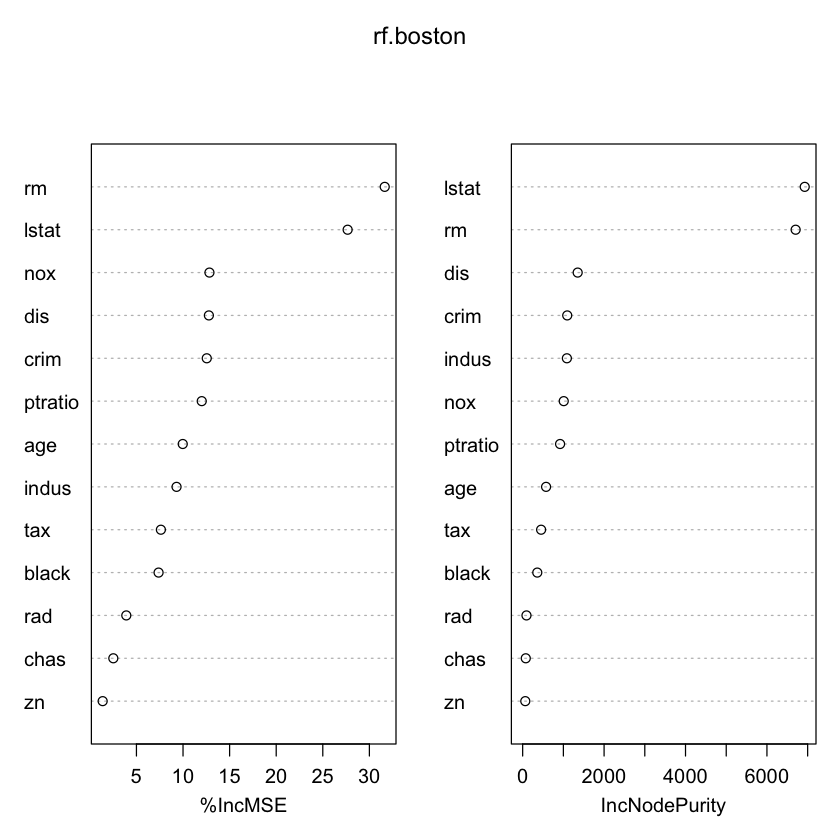

In [53]:
varImpPlot(rf.boston)

The results indicate that across all of the trees considered in the random forest, the wealth leel of the community (`lstat`) and the house size (`rm`) are by far the two most important variables.

<br><br><br>
## 8.3.4 Boosting

Here we use the `gbm` package, and within it the `gbm()` function, to fit boosted regression trees to the `Boston` data set. We run `gbm()` with the option `distribution="gaussian"` since this is a regression problem; if it were a binary classification problem, we would use `distribution="bernoulli"`. The argument `n.trees=5000` indicates that we want 5000 trees, and the option `interaction.depth=4` limits the depth of each tree.

In [77]:
library(gbm)
set.seed(1)
boost.boston=gbm(medv~.,data=Boston[train,],distribution="gaussian",
                 n.trees=5000,interaction.depth=4)

The `summary()` function produces a relative influence plot and also outputs the relative influence statistics.

We see that `lstat` and `rm` are by far the most important variables. We can also produce *partial dependence plots* for these two variables. These plots illustrate the marginal effect of the selected variables on the response after *integrating* out the other variables. In this case, as we might expect, median house prices are increasing with `rm` and decreasing with `lstat`.

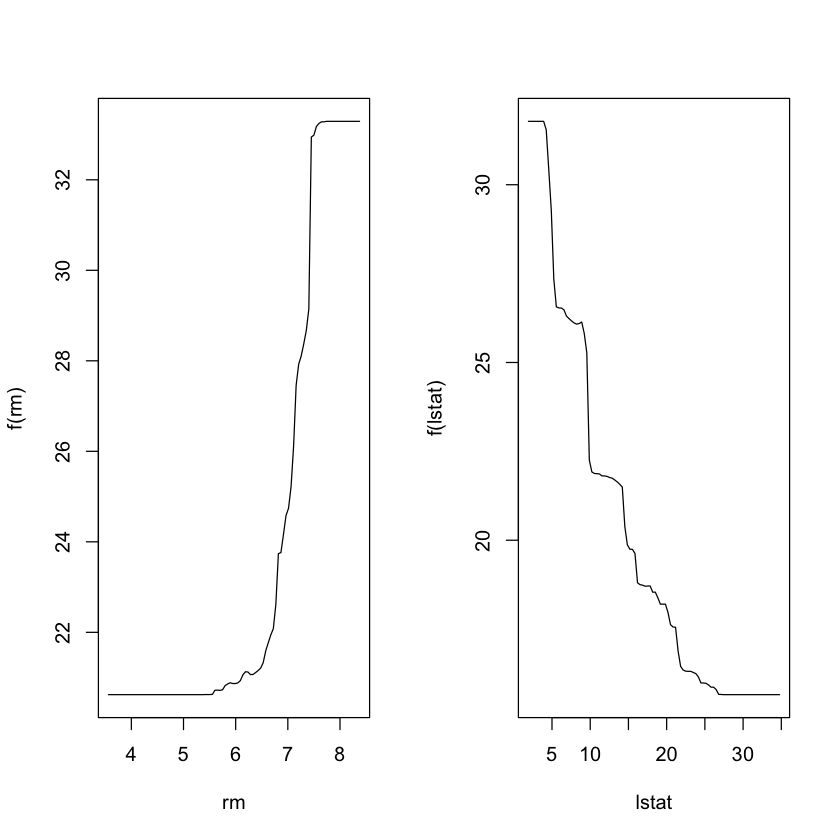

In [78]:
par(mfrow=c(1,2))
plot(boost.boston,i="rm")
plot(boost.boston,i="lstat")

We now use the boosted model to predict `medv` on the test set:

In [79]:
yhat.boost=predict(boost.boston,newdata=Boston[-train,],n.trees=5000)
mean((yhat.boost-boston.test)^2)

[1] 11.84434

The test MSE obtained is 11.8; similar to the test MSE for random forests and superior to that for bagging. If we want to, we can perform boosting with a different value of the shrinkage parameter $\lambda$ in (8.10). The default value is 0.001, but this is easily modified. Here we take $\lambda=0.2$.

In [80]:
boost.boston=gbm(medv~.,data=Boston[train,],distribution="gaussian",
                 n.trees=5000,interaction.depth=4,shrinkage=0.2,verbose=F)
yhat.boost=predict(boost.boston,newdata=Boston[-train,],n.trees=5000)
mean((yhat.boost-boston.test)^2)

[1] 11.51109

In this case, using $\lambda=0.2$ leads to a slightly lower test MSE than $\lambda=0.001$.